In [1]:
!pip install easydict
!pip install transformers

In [3]:
cd /content/drive/MyDrive/Legal-Document-Summarization-Competition

/content/drive/MyDrive/Legal-Document-Summarization-Competition


In [4]:
import easydict
import os
import pandas as pd
import torch
import modules.utils as utils
from torch.utils.data import Dataset
from transformers import AutoTokenizer
from itertools import chain
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

from pprint import pprint
import random

os.environ["TOKENIZERS_PARALLELISM"] = "true"

In [5]:
config = {}

# Essential
config['seed'] = 981201
config['device'] = "cuda" if torch.cuda.is_available() else "cpu"

# Directory
config['data_dir'] = '/content/drive/MyDrive/Legal-Document-Summarization-Competition/data'
config['model_dir'] = '/content/drive/MyDrive/Legal-Document-Summarization-Competition/model'
config['submission_dir'] = '/content/drive/MyDrive/Legal-Document-Summarization-Competition/submission'

# Name
config['train_file_name'] = 'train.json'
config['test_file_name'] = 'test.json'
config['test_model_name'] = 'suz.pt'
config['submission_name'] = '0630.json'
config['run_name'] = 'suz_0630'

# Model
config['model'] = 'base'
config['model_name'] = 'klue/bert-base'
config['optimizer'] = 'adamW'
config['hidden_dim'] = 768
config['batch_size'] = 16
config['criterion'] = 'bce'
config['num_workers']= 4

# Trainer
config['n_epochs'] = 1
config['num_workers'] = 1
config['lr'] = 5e-4

# Etc
config['log_steps'] = 50
config['fold'] = 0
config['train_kfold']= False
config['partial_dataset'] = 'small'


args = easydict.EasyDict(config)

In [6]:
with open(os.path.join(args.data_dir, "train.json"), "r", encoding="utf-8-sig") as f:
      data = pd.read_json(f) 
train_df = pd.DataFrame(data)

In [7]:
train_df.head()

,id,extractive,article_original
0,196524,"[13, 14, 15]","[[1] 의용 부동산등기법 제35조 제1항,, 제60조 제1항은 등기를 신청함에는 ..."
1,106984,"[1, 2, 4]",[가. 주택개량을 위하여 조합원들이 스스로 결성한 주택개량재개발조합이 실시하는 재개...
2,190919,"[1, 2, 3]","[금원의 목적 내지 성질상 국가나 지방자치단체와 특정인 사이에서만 수수,, 결제되어..."
3,110573,"[0, 2, 5]",[가. 자동차대여업자의 직원으로서는 운전면허 없는 운전자가 위조된 운전면허증의 복사...
4,156698,"[0, 2, 3]",[소외회사의 평리사 6명을 제쳐 놓고 대표이사 3명만의 결의에 의하여 동회사의 대표...


In [8]:
answers = list(train_df['extractive'])
articles = list(train_df['article_original'])

In [21]:
answer_length = []
total_length = []
a1_ratio = []
a2_ratio = []
a3_ratio = []

for i, article in enumerate(articles):
  a1, a2, a3 = [len(article[answer])for answer in answers[i]]
  total_length.append(sum([len(article[idx]) for idx in range(len(article))]))
  a1_ratio.append(a1 / total_length[-1])
  a2_ratio.append(a2 / total_length[-1])
  a3_ratio.append(a3 / total_length[-1])

In [22]:
train_df['a1_ratio'] = a1_ratio
train_df['a2_ratio'] = a2_ratio
train_df['a3_ratio'] = a3_ratio

In [23]:
train_df.head()

,id,extractive,article_original,ratio,a1_ratio,a2_ratio,a3_ratio
0,196524,"[13, 14, 15]","[[1] 의용 부동산등기법 제35조 제1항,, 제60조 제1항은 등기를 신청함에는 ...",0.396307,0.129261,0.078125,0.188920
1,106984,"[1, 2, 4]",[가. 주택개량을 위하여 조합원들이 스스로 결성한 주택개량재개발조합이 실시하는 재개...,0.397004,0.185393,0.164794,0.046816
2,190919,"[1, 2, 3]","[금원의 목적 내지 성질상 국가나 지방자치단체와 특정인 사이에서만 수수,, 결제되어...",0.857664,0.218978,0.536496,0.102190
3,110573,"[0, 2, 5]",[가. 자동차대여업자의 직원으로서는 운전면허 없는 운전자가 위조된 운전면허증의 복사...,0.619217,0.197509,0.263345,0.158363
4,156698,"[0, 2, 3]",[소외회사의 평리사 6명을 제쳐 놓고 대표이사 3명만의 결의에 의하여 동회사의 대표...,0.817204,0.387097,0.309140,0.120968


(array([5.063e+03, 7.591e+03, 5.242e+03, 3.140e+03, 1.713e+03, 7.700e+02,
        3.450e+02, 1.230e+02, 3.400e+01, 6.000e+00]),
 array([0.00470263, 0.08551315, 0.16632368, 0.2471342 , 0.32794473,
        0.40875525, 0.48956578, 0.57037631, 0.65118683, 0.73199736,
        0.81280788]),
 <a list of 10 Patch objects>)

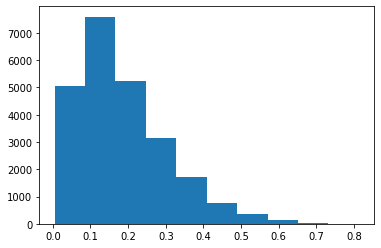

In [25]:
import matplotlib.pyplot as plt

plt.hist(train_df['a1_ratio'])

(array([6.174e+03, 8.138e+03, 4.983e+03, 2.648e+03, 1.269e+03, 5.350e+02,
        2.000e+02, 6.400e+01, 1.300e+01, 3.000e+00]),
 array([0.0066325 , 0.08887248, 0.17111245, 0.25335243, 0.3355924 ,
        0.41783238, 0.50007235, 0.58231233, 0.66455231, 0.74679228,
        0.82903226]),
 <a list of 10 Patch objects>)

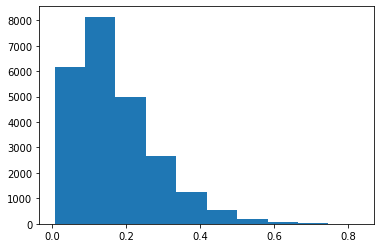

In [28]:
plt.hist(train_df['a2_ratio'])

(array([7.576e+03, 7.952e+03, 4.470e+03, 2.240e+03, 1.043e+03, 4.730e+02,
        1.910e+02, 6.000e+01, 1.700e+01, 5.000e+00]),
 array([0.00548112, 0.09042919, 0.17537726, 0.26032533, 0.34527341,
        0.43022148, 0.51516955, 0.60011762, 0.68506569, 0.77001376,
        0.85496183]),
 <a list of 10 Patch objects>)

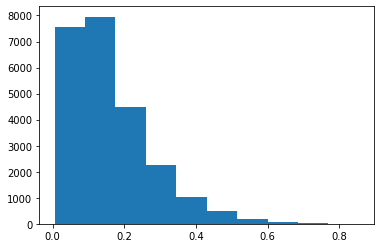

In [27]:
plt.hist(train_df['a3_ratio'])

In [ ]:
while True:
  pass